### 1. Data

### Graphs setup

Based on the available data, you will create two graphs to model our relationships as follows:

1.Citation graph: This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

2.Collaboration graph: This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

### Data pre-processing
The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components.

As a result, you will attempt to approximate that most connected component by performing the following steps:

1.Identify the top 10,000 papers with the highest number of citations.

2.Then the nodes of your graphs would be as follows:

Citation graph: you can consider each of the papers as your nodes

Collaboration graph: the authors of these papers would be your nodes

3.For the edges of the two graphs, you would have the following cases:

Citation graph: only consider the citation relationship between these 10,000 papers and ignore the rest.

Collaboration graph: only consider the collaborations between the authors of these 10,000 papers and ignore the rest.

In [2]:
# first import required libraries:
import pandas as pd
import numpy as np
import ijson
import matplotlib.pyplot as plt
import networkx as nx
import time
import os
from tqdm.notebook import tqdm
import ast

Due to the voluminous nature of the data, it is necessary to convert it into a CSV file for the purpose of cleaning and reducing its size.The code was initially on Kaggle but required some modifications for optimal performance. After converting it into a CSV file, we can efficiently handle the data in less time. Following the specified details in the question, I transformed the number of citations into numeric values. Subsequently, I sorted the data to identify the top 10,000 papers with the highest number of citations.

In [2]:
# json file path in my local memory
json_file_path = r'C:\Users\LENOVO\Desktop\UNI\02-ADM\homework5\dblp.v12.json'

articles = []

# iterating through all the papers in json file and clean the data and append them into 'articles' list
with open(json_file_path, "rb") as f:
    for i, element in tqdm(enumerate(ijson.items(f, "item"))):
       
        paper1={}

        paper1['id'] = element['id']

        paper1['title'] = element['title']

        authors =element.get('authors')
        if authors:
            paper1['authors'] = authors
        else:
            paper1['authors'] = np.nan

        year = element.get('year')
        if year:
            paper1['year'] = year
        else:
            paper1['year'] = np.nan

        n_citation = element.get('n_citation')
        if n_citation:
            paper1['n_citation'] = element['n_citation']
        else:
            paper1['n_citation'] = 0
            
        references = element.get('references')
        if references:
            paper1['reference_count'] = len(references)
            # joining all refs id in a `;` seperated string
            paper1['references'] = ';'.join([str(int(r)) for r in references])
        else:
            paper1['reference_count'] = np.nan
            paper1['references'] = np.nan

        publisher = element.get('publisher')
        if publisher:
            paper1['publisher'] = element['publisher']
        else:
            paper1['publisher'] = np.nan

        doc_type = element.get('doc_type')
        if doc_type:
            paper1['doc_type'] = element['doc_type']
        else:
            paper1['doc_type'] = np.nan
            
        doi = element.get('doi')
        if doi:
            paper1['doi']= f"https://doi.org/{element['doi']}"
        else:
            paper1['doi']= np.nan 
            
        #append each paper as a dict to the 'articles' list
        articles.append(paper1)

0it [00:00, ?it/s]

In [3]:
# the number of all the papers which should be 4,894,081
len(articles)

4894081

In [4]:
df = pd.DataFrame(articles)
df

,id,title,authors,year,n_citation,reference_count,references,publisher,doc_type,doi
0,1091,Preliminary Design of a Network Protocol Learn...,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",2013.0,1,2.0,2005687710;2018037215,"Springer, Berlin, Heidelberg",Conference,https://doi.org/10.1007/978-3-642-39476-8_19
1,1388,Further Results on Independence in Direct-Prod...,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",2000.0,1,NaN,NaN,NaN,Journal,NaN
2,1674,A methodology for the physically accurate visu...,"[{'name': 'G. Beale', 'org': 'Archaeological C...",2011.0,1,15.0,1535888970;1992876689;1993710814;2035653341;20...,Eurographics Association,Conference,https://doi.org/10.2312/VAST/VAST11/137-144
3,1688,"Comparison of GARCH, Neural Network and Suppor...","[{'name': 'Altaf Hossain', 'org': 'Department ...",2009.0,6,3.0,1560724230;1986968751;2156909104,"Springer, Berlin, Heidelberg",Conference,https://doi.org/10.1007/978-3-642-11164-8_97
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",2009.0,0,NaN,NaN,NaN,Conference,NaN
...,...,...,...,...,...,...,...,...,...,...
4894076,99905544,A Naïve-Bayesian methodology to classify echo ...,"[{'name': 'S. Nandagopalan', 'org': 'Dept. of ...",2010.0,2,8.0,1562217771;1625504505;2015022770;2108751703;21...,"Springer, Berlin, Heidelberg",Conference,https://doi.org/10.1007/978-3-642-24788-0_15
4894077,99884553,Blind Equalization for underwater communications,"[{'name': 'Koen Cornelis Hubertus Blom', 'org'...",2014.0,0,NaN,NaN,University of Twente,NaN,https://doi.org/10.3990/1.9789036536806
4894078,999847014,Technical Implementation and Feasibility,"[{'name': 'Gert Læssøe Mikkelsen', 'org': 'Ale...",2015.0,1,6.0,1940933138;1975620021;1978183200;2097595927;21...,Springer International Publishing,NaN,https://doi.org/10.1007/978-3-319-14439-9_9
4894079,9990887,Knowledge Patterns in Databases,"[{'name': 'Rajesh Natarajan', 'org': 'Indian I...",2011.0,0,NaN,NaN,IGI Global,NaN,https://doi.org/10.4018/978-1-59904-931-1.ch081


In [5]:
# turn the 'n_citation' column into numeric values
df['n_citation'] = pd.to_numeric(df['n_citation'], errors='coerce')

In [6]:
# sort the data to identify the top 10,000 papers with the highest number of citations
df_sorted = df.sort_values('n_citation', ascending=False)
sliced_df = df_sorted.head(10000)
# turn the sliced data into a new csv file
sliced_df.to_csv('sorted_sliced_10,000_data.csv', index=False)

In [3]:
# Now, we can utilize the path of the CSV file to handle the data seamlessly
file_path=r'C:\Users\LENOVO\Desktop\UNI\02-ADM\homework5\final\sorted_sliced_10,000_data.csv'
df_10000=pd.read_csv(file_path)
df_10000

,id,title,authors,year,n_citation,reference_count,references,publisher,doc_type,doi
0,2041404167,The Mathematical Theory of Communication,"[{'name': 'C. E. Shannon', 'org': 'External Or...",1949.0,48327,NaN,NaN,NaN,Book,NaN
1,1639032689,"Genetic algorithms in search, optimization, an...","[{'name': 'David E. Goldberg', 'id': 2102678951}]",1989.0,44175,NaN,NaN,NaN,Book,NaN
2,2912565176,Fuzzy sets,"[{'name': 'Lotfi A. Zadeh', 'id': 2252586558}]",1996.0,42437,NaN,NaN,NaN,NaN,NaN
3,2151103935,Distinctive Image Features from Scale-Invarian...,"[{'name': 'David G. Lowe', 'org': 'Computer Sc...",2004.0,35541,33.0,19720318;1541642243;1560959218;1676552347;1681...,Kluwer Academic Publishers,Journal,https://doi.org/10.1023/B:VISI.0000029664.9961...
4,2911964244,Random Forests,"[{'name': 'Leo Breiman', 'org': 'Statistics De...",2001.0,34741,11.0,1507255258;1580948147;1605688901;1975846642;20...,NaN,NaN,https://doi.org/10.1023/A:1010933404324
...,...,...,...,...,...,...,...,...,...,...
9995,1964830323,An overview of JML tools and applications,"[{'name': 'Lilian Burdy', 'org': 'INRIA Sophia...",2005.0,596,82.0,1486696980;1489778371;1492315860;1498946538;14...,Springer-Verlag,Conference,https://doi.org/10.1007/s10009-004-0167-4
9996,2060553764,Trust and e-commerce: a study of consumer perc...,"[{'name': 'Brian J. Corbitt', 'org': 'School o...",2003.0,596,7.0,1492586516;1515344919;1572145800;1704743582;17...,Elsevier,Journal,https://doi.org/10.1016/S1567-4223(03)00024-3
9997,2068691410,Geographic routing in city scenarios,"[{'name': 'Christian Lochert', 'org': 'Heinric...",2005.0,596,4.0,1554193878;2101963262;2151800518;2156689181,ACM,Journal,https://doi.org/10.1145/1055959.1055970
9998,2147343704,EVENODD: an efficient scheme for tolerating do...,"[{'name': 'M. Blaum', 'org': 'IBM Almaden Rese...",1995.0,596,9.0,1530042190;1531975040;1820898047;1829547464;20...,IEEE Computer Society,Journal,https://doi.org/10.1109/12.364531


### Citation Graph:

This graph should represent the paper's citation relationships.<br>

1. Let's create a graph and name it.<br>
2. It should be **unweighted** and **directed**.<br>
3. Nodes: each of the papers as your nodes
   - Generating a list of nodes based on the id
   - Add attributes to each node based on the other columns of the dataframe<br>

4. Edges: the citation relationship between these 10,000 papers
   - Generating edges based on the citation found in the **'references'** column
   - When generating edges, check for this line of the assignment: only consider the citation relationship between these 10,000 papers and ignore the rest.

In [4]:
#  Citation Graph:
G_citation=nx.DiGraph()
G_citation.name = "citation graph"

In [5]:
# Generating a list of valid node IDs
valid_node_ids = [int(node) for node in df_10000['id']]

# iterating through all rows to generate nodes with their attributes
for index, row in df_10000.iterrows():
    
    attributes={}
    for i in list(df_10000.columns[1:]):
        attributes[i]=row[i]
    
    source_node = row['id'] 
    
    G_citation.add_node(source_node, **attributes)  
    
    # check for references column which are our nodes
    if not pd.isna(row['references']):
        #list of edges for each node
        edges = [int(x) for x in row['references'].split(';')]
        for target_node in edges:
            # remove nodes that are not among the valid 10,000 nodes
            if target_node in valid_node_ids:
                G_citation.add_edge(source_node, target_node)
                
    # Check for an empty references column; if nodes meet this condition, they are
    # generated without any edges
    elif pd.isna(row['references']):
        G_citation.add_node(row['id'])
    
print(f"Total number of nodes in the citation graph : {len(G_citation.nodes())}")
print(f"Total number of edges in the citation graph : {len(G_citation.edges())}")

Total number of nodes in the citation graph : 10000
Total number of edges in the citation graph : 52252


In [6]:
# check for a random node inorder to check the attribute
G_citation.nodes()[2041404167]

{'title': 'The Mathematical Theory of Communication',
 'authors': "[{'name': 'C. E. Shannon', 'org': 'External Organizations', 'id': 2247248564}]",
 'year': 1949.0,
 'n_citation': 48327,
 'reference_count': nan,
 'references': nan,
 'publisher': nan,
 'doc_type': 'Book',
 'doi': nan}

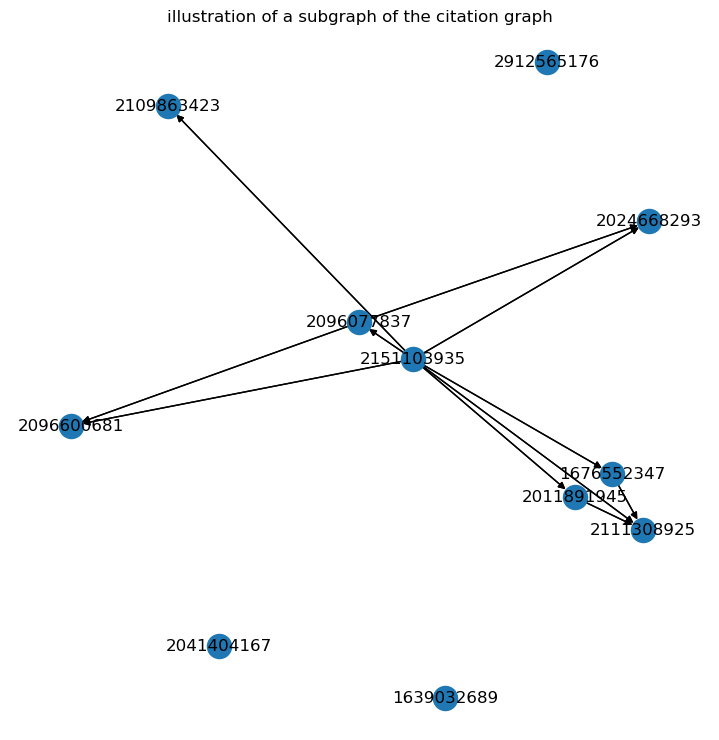

In [7]:
# Generating a subgraph of nodes for illustration purposes.
sub_graph = G_citation.subgraph(list(G_citation.nodes())[:11])
position = nx.spring_layout(sub_graph)
plt.figure(figsize=(7,7))
nx.draw(sub_graph, with_labels=True, pos= position)
nx.draw_networkx_edges(sub_graph, pos=position)
plt.title('illustration of a subgraph of the citation graph')
plt.show()

### Collaboration graph

This graph should represent the collaborations of the paper's authors.<br>
1-let's create a graph and name it.<br>
2-it should be **weighted** and **undirected**.<br>
3-nodes: the authors of these papers(10,000 papers) are nodes<br>
 - generating set and list of nodes based on the id of each author
 - add attributes to each nodes based on the data provided for each author+ the name of their articles<br>
 
4-edges: only consider the collaborations between the authors of these 10,000 papers and ignore the rest.<br>
 - generating edges based on the collaboration of aech author with their peers on a paper<br>
 - When generating edges, assign weights to the graph based on the number of collaborations each author has had with their peers.

In [8]:
#  collaboration Graph:
G_collab=nx.Graph()
G_collab.name = "collaboration graph"

In [9]:
# import required library:
from itertools import combinations

# Create a set to ensure the uniqueness of author's IDs.
nodes_set = set()

# iterating through all rows to generate nodes with their attributes
for index, row in df_10000.iterrows():  
    # create a list of authors for each paper and iterate through each
    # author to add nodes and edges to the graph
    list_id_authors=[]
    for aouthor in ast.literal_eval(row['authors']):
        list_id_authors.append(aouthor['id'])
        # Node does not exist we should create it with its attribute
        if aouthor['id'] not in nodes_set:
            #attributes of each node
            attributes={'articles':[]}
            attributes['name']=aouthor['name']
            attributes['articles'].append(row['title'])
            if 'org' in aouthor:
                attributes['org']=aouthor['org']
            #generating each node with its attribute for the first time
            G_collab.add_node(aouthor['id'],**attributes)
            #add node to the node sets to check the uniqueness and update attributes
            nodes_set.add(aouthor['id'])
            
        #if nodes exist, then just update the 'article' attribute
        elif aouthor['id'] in nodes_set:
            current_articles = G_collab.nodes[aouthor['id']]['articles']
            current_articles.extend([row['title']])
            G_collab.nodes[aouthor['id']]['articles'] = current_articles
    
    # check all the papers have authors information        
    if len(list_id_authors)<1:
        print(f"there is no aouthor in this {index}")
        
    # Generate edges for nodes and assign each edge a weight based on the number of collaborations between authors 
    elif len(list_id_authors)==2:
        source_node=list_id_authors[0]
        target_node=list_id_authors[1]
        if  G_collab.has_edge(source_node, target_node):
            G_collab[source_node][target_node]['weight'] += 1
        else: 
            G_collab.add_edge(source_node, target_node,weight=1)
            
    # Generate edges for nodes and assign each edge a weight based on the number of collaborations between authors 
    elif len(list_id_authors)>2:
        all_combinations = list(combinations(list_id_authors, 2))
        for combination in all_combinations:
            source_node=combination[0]
            target_node=combination[1]
            if  G_collab.has_edge(source_node, target_node):
                G_collab[source_node][target_node]['weight'] += 1
            else: 
                G_collab.add_edge(source_node, target_node,weight=1)
        
print(f"Total number of nodes in the collaboration graph : {len(G_collab.nodes())}")
print(f"Total number of edges in the collaboration graph : {len(G_collab.edges())}")

Total number of nodes in the collaboration graph : 21235
Total number of edges in the collaboration graph : 136478


In [10]:
# to check the attribute of the most active author in the first 10,000 papers with the highest number of citation
G_collab.nodes()[161269817]

{'articles': ['Deep Learning',
  'Generative Adversarial Nets',
  'Neural Machine Translation by Jointly Learning to Align and Translate',
  'Understanding the difficulty of training deep feedforward neural networks',
  'Representation Learning: A Review and New Perspectives',
  'Learning Deep Architectures for AI',
  'A neural probabilistic language model',
  'Stacked Denoising Autoencoders: Learning Useful Representations in a Deep Network with a Local Denoising Criterion',
  'Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation',
  'Extracting and composing robust features with denoising autoencoders',
  'Greedy Layer-Wise Training of Deep Networks',
  'Learning long-term dependencies with gradient descent is difficult',
  'Empirical evaluation of gated recurrent neural networks on sequence modeling',
  'Show, Attend and Tell: Neural Image Caption Generation with Visual Attention',
  'Random search for hyper-parameter optimization',
  'Learni

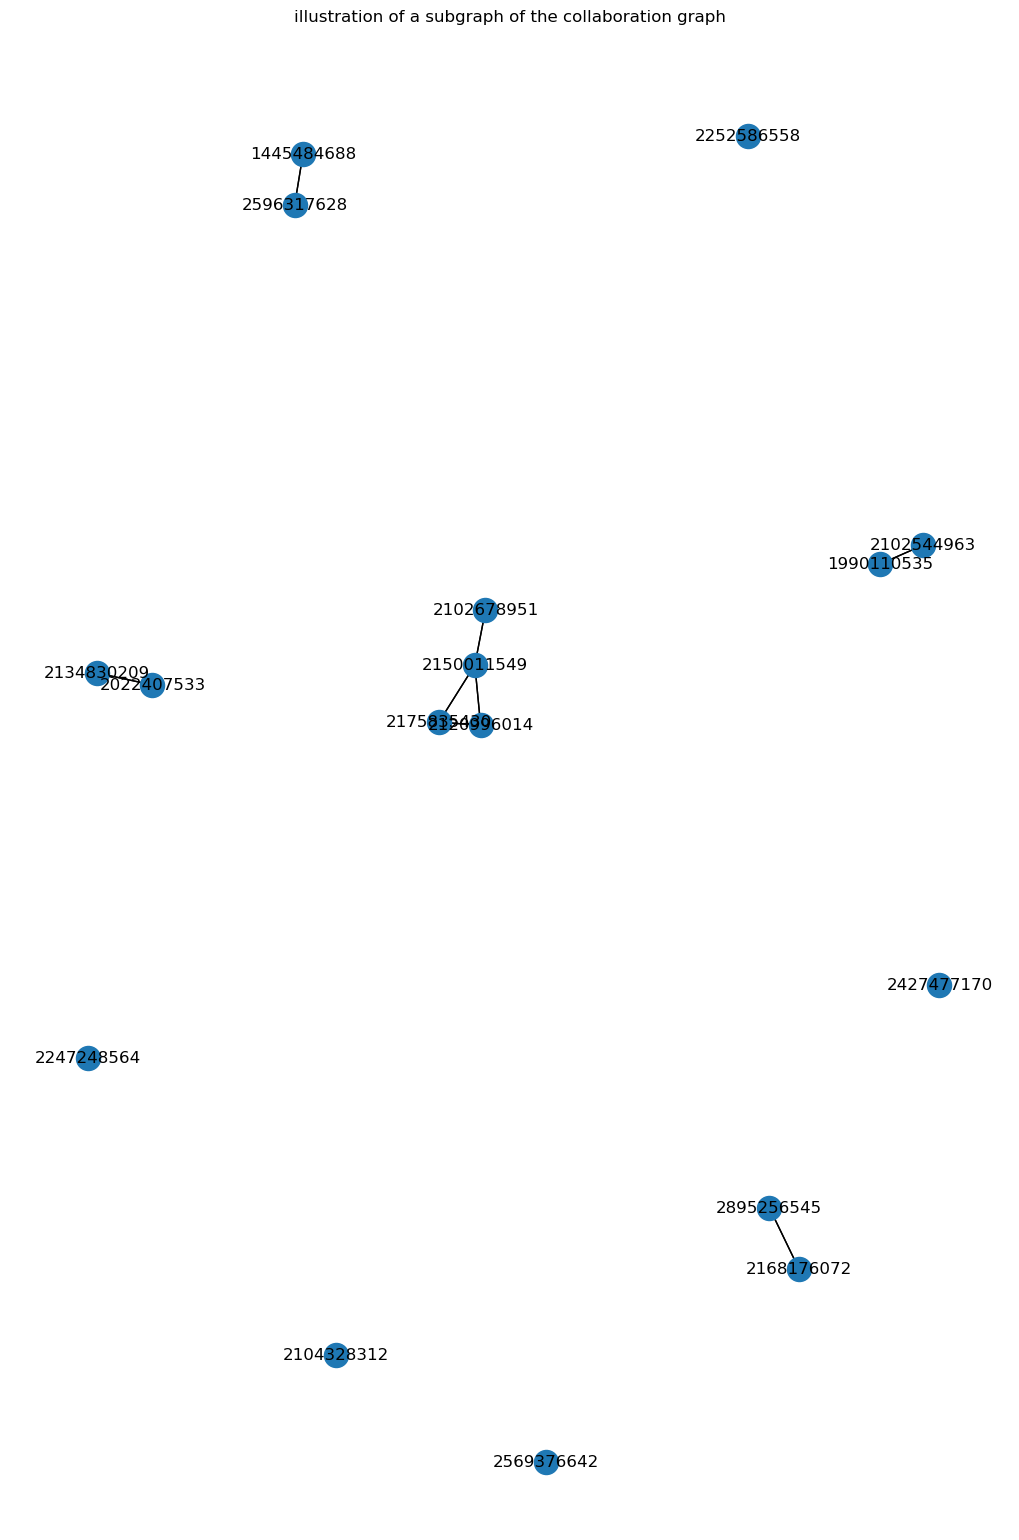

In [11]:
# Generating a subgraph of nodes for illustration purposes.
sub_collab_graph = G_collab.subgraph(list(G_collab.nodes())[:17])
position = nx.spring_layout(sub_collab_graph)
plt.figure(figsize=(10,15))
nx.draw(sub_collab_graph, with_labels=True, pos= position)
nx.draw_networkx_edges(sub_collab_graph, pos=position)
plt.title('illustration of a subgraph of the collaboration graph')
plt.show()